In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dropout, Dense, Input, Concatenate, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd

from data_prep import transurban_load, daylight_fix, scats_load, inci_load, inci_align
from data_prep import input_prep, plot_loss, evaluate, transurban_imports, scats_imports

Using TensorFlow backend.


In [41]:
def evaluate(dats, model, scaler, predictsteps, lookbacksteps):
    train_X = dats[0]
    train_y = dats[1]
    test_X = dats[2]
    test_y = dats[3]

    yhat = model.predict(test_X)

    # Rescale values
    #train_rescpred=scaler.inverse_transform(ythat)
    test_rescpred=scaler.inverse_transform(yhat)
    #train_rescref=scaler.inverse_transform(train_y)
    test_rescref=scaler.inverse_transform(test_y)

    # Naive prediction benchmark (using previous observed value)
    #testnpred=np.array(test_X).transpose(1,0,2)[-1]
    #testnpredc=scaler.inverse_transform(testnpred)

    ## Performance measures
    seg_mael=[] #MAE list over detectors
    # seg_masel=[] #MASE list over detectors - this should use the historical norm
    seg_nmael=[] #Naive MAE list over detectors 
    #mape list over detectors
    seg_mape = []
    #Naive Mape
    seg_nmape = []

    for j in range(train_X.shape[-1]):
        
        seg_mael.append(np.mean(np.abs(test_rescref.T[j]-test_rescpred.T[j]))) #Mean Absolute Error
        seg_mape.append(np.mean(np.abs((test_rescref.T[j] - test_rescpred.T[j]) / test_rescref.T[j])) * 100)
        
        #seg_nmael.append(np.mean(np.abs(test_rescref.T[j]-testnpredc.T[j]))) #Mean Absolute Error for naive prediction
        #seg_nmape.append(np.mean(np.abs((test_rescref.T[j] - testnpredc.T[j]) / test_rescref.T[j])) * 100)
        # if seg_nmael[-1] != 0:
        #     seg_masel.append(seg_mael[-1]/seg_nmael[-1]) #Ratio of the two: Mean Absolute Scaled Error
        # else:
        #     seg_masel.append(np.NaN)
    
    return (np.array(seg_mael), np.array(seg_nmael), np.array(seg_mape), np.array(seg_nmape), test_rescpred, test_rescref)


In [42]:
def prepare_data(datatrain, datatest, time_train, time_test, pred=1, lb=1):
    train_dat = np.array(datatrain)
    train_dat = np.nan_to_num(train_dat)
    test_dat = np.array(datatest)
    test_dat = np.nan_to_num(test_dat)
    predictsteps = pred
    lookbacksteps = lb

    #Scale on training data (fit and transform)
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_dat = train_dat.astype('float32')
    train_scaled = scaler.fit_transform(train_dat)
    test_scaled = scaler.transform(test_dat)

    train_X=[]
    train_y=[]
    test_X=[]
    test_y=[]

    for j in range(len(train_scaled)-int(predictsteps+lookbacksteps-1)):
        if (time_train[j]<=lb) or (time_train[int(predictsteps+lookbacksteps-1)+j]<lb):
            continue
    #print(time_train[j])
        train_datset=train_scaled[j:lookbacksteps+j,1:]
        #print(train_datset)
        train_ycomp=train_scaled[int(predictsteps+lookbacksteps-1)+j]
        train_X.append(train_datset)
        train_y.append(train_ycomp)

    for j in range(len(test_scaled)-int(predictsteps+lookbacksteps-1)):
        if (time_test[j]<=lb) or (time_test[int(predictsteps+lookbacksteps-1)+j]<lb):
            continue
        test_datset=test_scaled[j:lookbacksteps+j,1:]
        test_ycomp=test_scaled[int(predictsteps+lookbacksteps-1)+j]
        test_X.append(test_datset)
        test_y.append(test_ycomp)

    train_X = np.array(train_X)
    train_y = np.array(train_y)
    test_X = np.array(test_X)
    test_y = np.array(test_y)
    return (train_X, train_y, test_X, test_y, scaler)

In [43]:
def train_nn(train_X, train_y, test_X, test_y, scaler, pred, lb):
    #Model creation
    inputt = Input(shape=(train_X.shape[1],train_X.shape[2],), name='t_input')
    #inputs = Input(shape=(train_X2.shape[1],train_X2.shape[2],), name='s_input')
    #c = Concatenate(-1)([inputt,inputs])
    #seg_num = train_X.shape[-1]+train_X2.shape[-1]
    #seg_num = train_X.shape[-1]
    #h1 = Conv1D(filters=64, kernel_size=5, padding='valid', activation='relu', strides=1)(inputt)
    #h2 = MaxPooling1D(pool_size=4)(h1)
    #h3 = LSTM(32, return_sequences=False)(h2)
    h3 = LSTM(64, return_sequences=False)(inputt)
    outp1 = Dense(train_X.shape[-1]+1)(h3)
    #outp2 = Dense(train_X2.shape[-1])(h3)
    #model = Model(inputs=[inputt,inputs], outputs=[outp1,outp2])
    model = Model(inputs=[inputt], outputs=[outp1])
    #Compile and fit
    model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    history = model.fit({'t_input': np.array(train_X)}, [np.array(train_y)], epochs=100, batch_size=50, verbose=0, validation_data=[[test_X], [test_y]])

    #Plot loss functions
    plot_loss(history)

    #Save model
    #filepath=...
    #model.save(filepath)

    #Evaluate
    dats=(train_X, train_y, test_X, test_y)
    (mael, nmael, mape, nmape, test_rescpred, test_rescref) = evaluate(dats, model, scaler, pred, lb)
    print('Model MAE: '+str(np.mean(mael)))
    print('Naive MAE: '+str(np.mean(nmael)))
    print('Model MAPE: '+str(np.mean(mape)))
    print('Naive MAPE: '+str(np.mean(nmape)))

    plt.clf()
    for j in [0,1,2,3,4,5]:
        plt.plot(test_rescref.T[j], color='C'+str(j))
        plt.plot(test_rescpred.T[j], '--', color='C'+str(j))
    plt.show()
    return (test_rescpred, test_rescref)


Test data:  1
Step ahead:  1


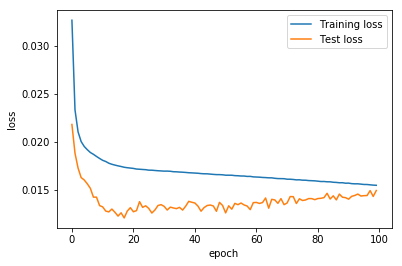

Model MAE: 2.135423776589657
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


C:\Users\ngu124\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\ngu124\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ngu124\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


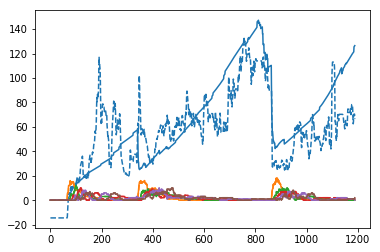

Step ahead:  2


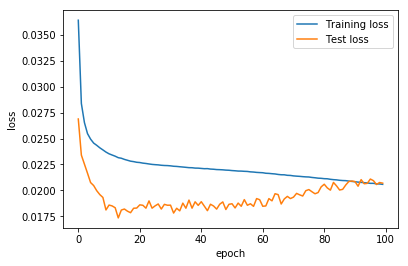

Model MAE: 2.3471402184494057
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


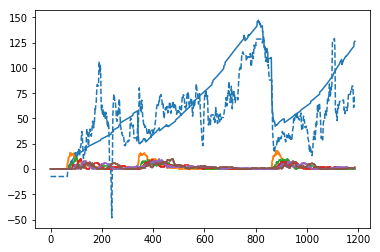

Step ahead:  3


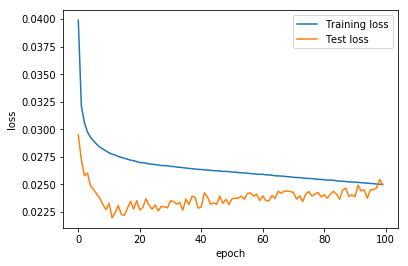

Model MAE: 2.423119578089241
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


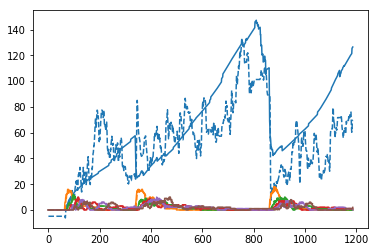

Step ahead:  4


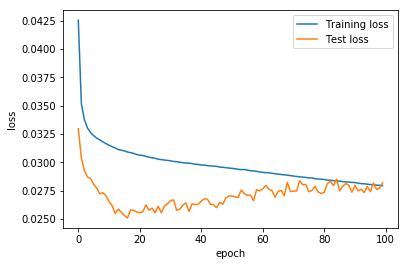

Model MAE: 2.550029822124898
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


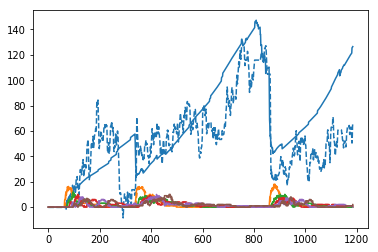

Step ahead:  5


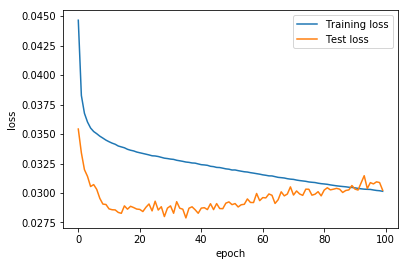

Model MAE: 2.4986165884114846
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


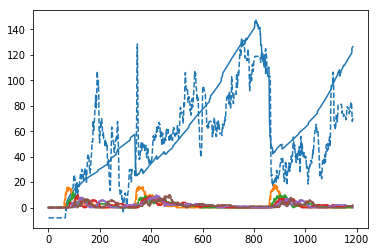

Test data:  2
Step ahead:  1


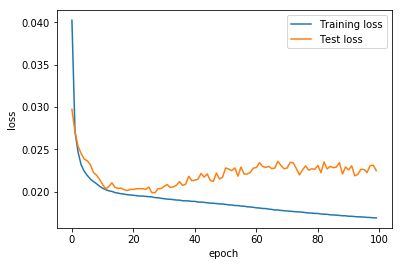

Model MAE: 3.4317331043826123
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


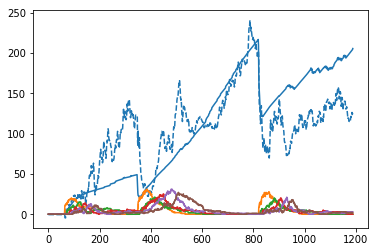

Step ahead:  2


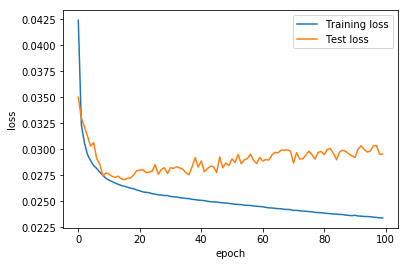

Model MAE: 3.7061689626690457
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


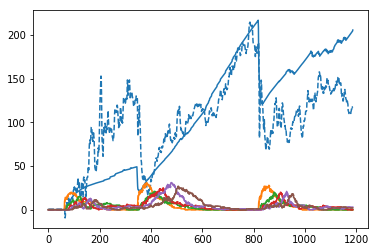

Step ahead:  3


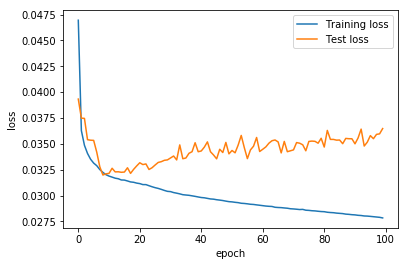

Model MAE: 3.982129384923926
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


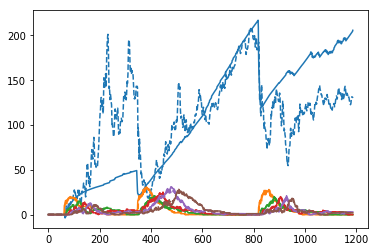

Step ahead:  4


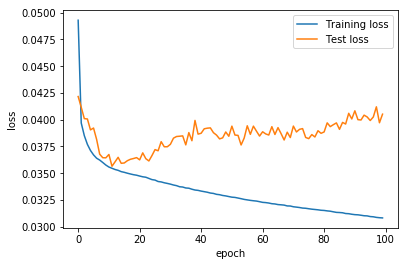

Model MAE: 3.887150116724258
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


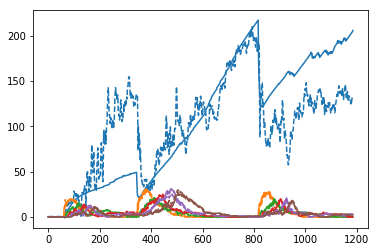

Step ahead:  5


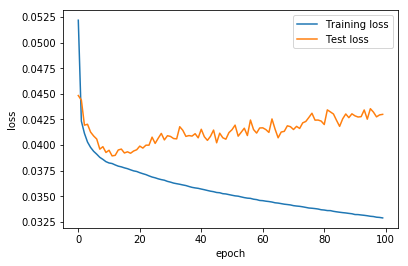

Model MAE: 3.79374946868867
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


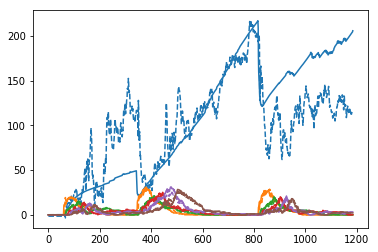

Test data:  3
Step ahead:  1


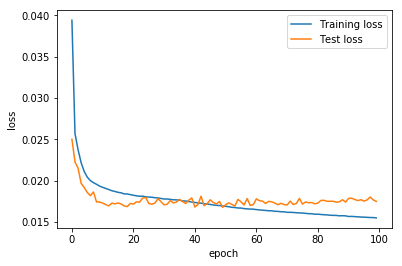

Model MAE: 2.6200965324624628
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


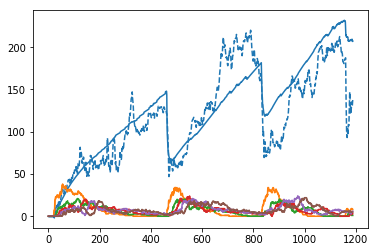

Step ahead:  2


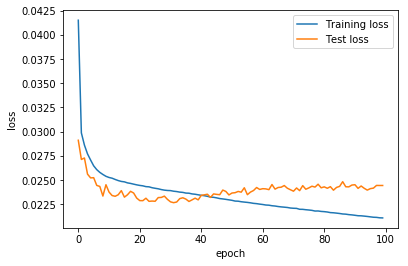

Model MAE: 2.9643632738900614
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


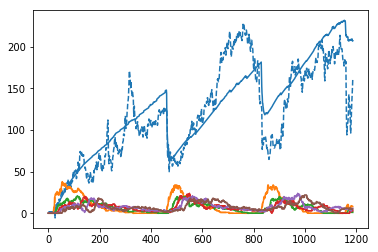

Step ahead:  3


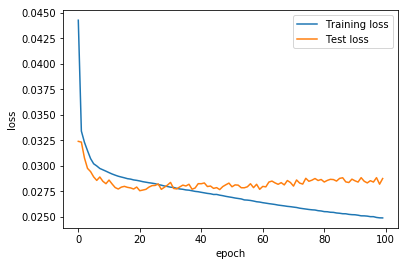

Model MAE: 3.1179152091688556
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


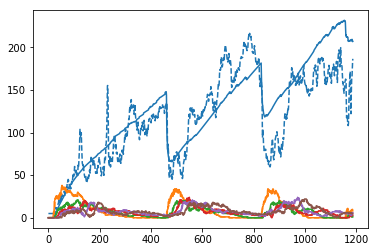

Step ahead:  4


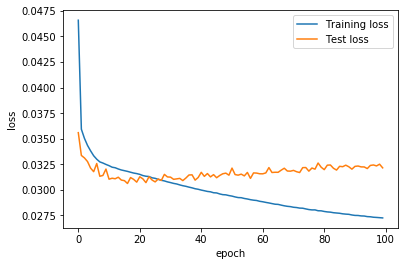

Model MAE: 3.3330134258334647
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


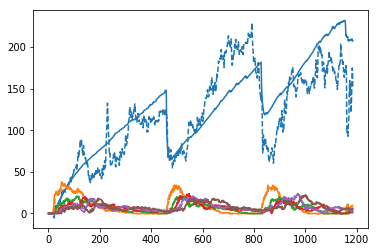

Step ahead:  5


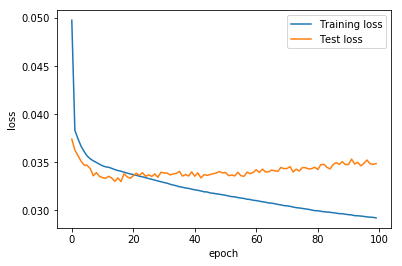

Model MAE: 3.342695715599068
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


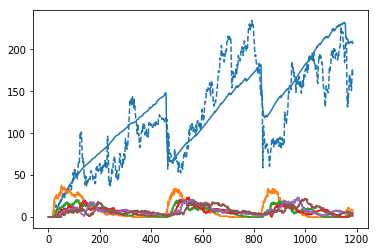

Test data:  4
Step ahead:  1


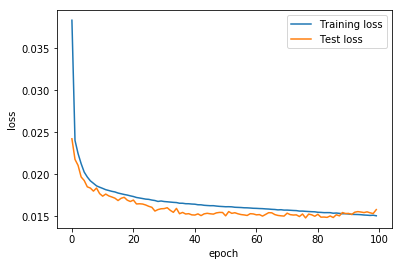

Model MAE: 2.1313923480858885
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


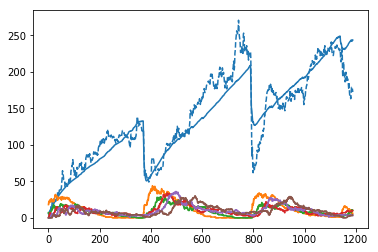

Step ahead:  2


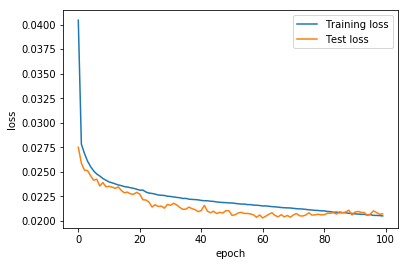

Model MAE: 1.9971112530361292
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


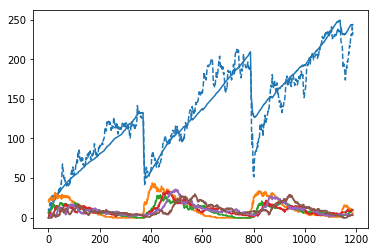

Step ahead:  3


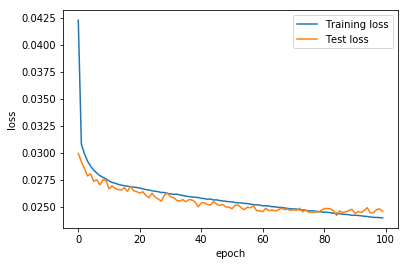

Model MAE: 2.140894476902549
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


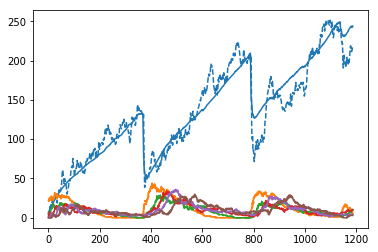

Step ahead:  4


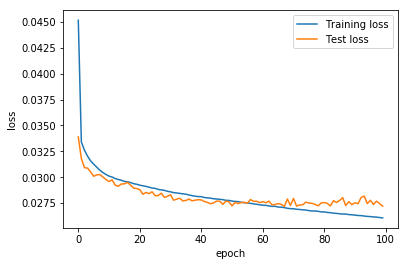

Model MAE: 2.2322443705872437
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


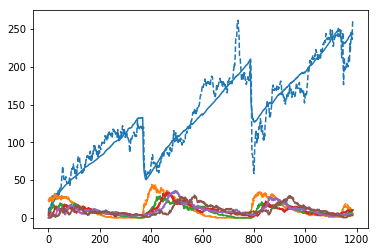

Step ahead:  5


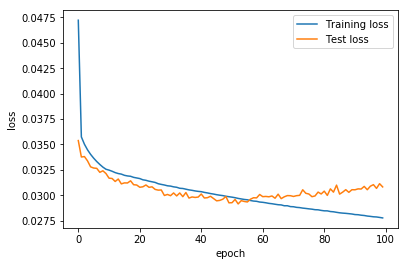

Model MAE: 2.723953424812969
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


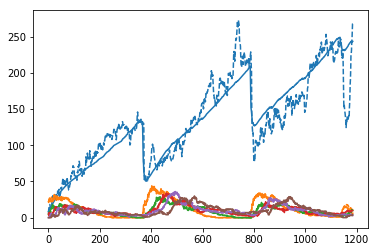

Test data:  5
Step ahead:  1


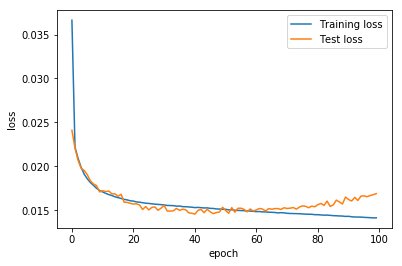

Model MAE: 3.2509213033727997
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


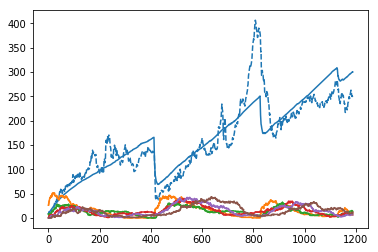

Step ahead:  2


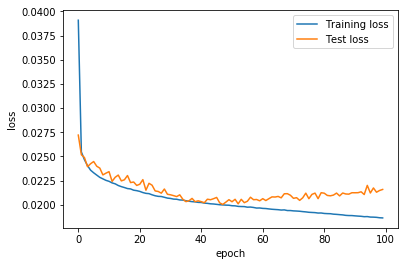

Model MAE: 3.179555020287979
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


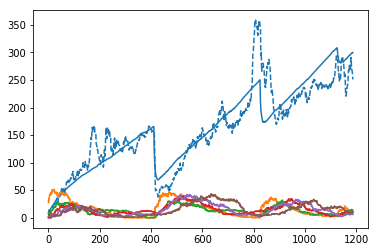

Step ahead:  3


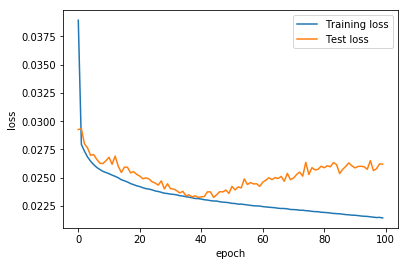

Model MAE: 3.7304698914785055
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


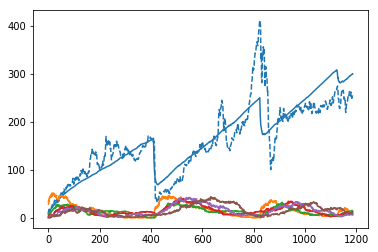

Step ahead:  4


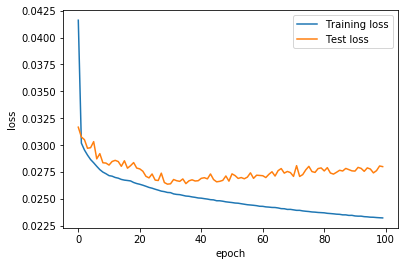

Model MAE: 3.3926796239473567
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


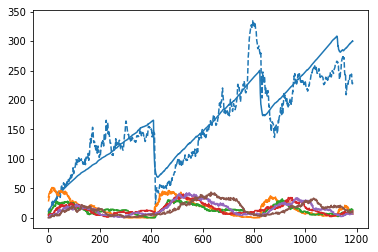

Step ahead:  5


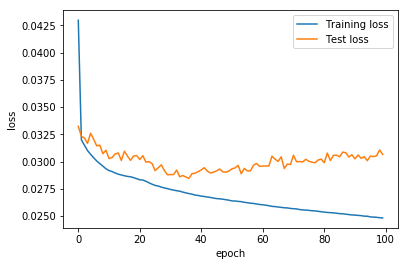

Model MAE: 3.6351826027695444
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


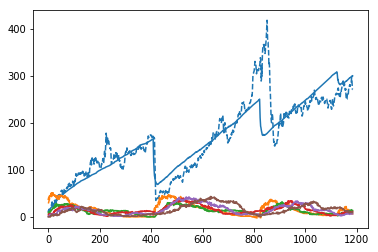

In [44]:
#train and test on each dataset
for k in range(1,6):
    print("Test data: ", k)
    df_train = pd.read_csv('./Agent_data/df_pop_'+str(k)+'00_v5.csv')
    time_train = df_train['# Time']
    df_train = df_train.drop(['# Time'], axis=1)
    df_train = df_train.drop(['Collisions'], axis=1)
    df_test = pd.read_csv('./Agent_data/df_pop_'+str(k)+'00_test_v5.csv')
    time_test = df_test['# Time']    
    df_test = df_test.drop(['# Time'], axis=1)
    df_test = df_test.drop(['Collisions'], axis=1)
    #df_test
    datatrain = df_train.values
    datatest = df_test.values
    for m in range(1,6):
        print("Step ahead: ", m)
        train_X, train_y, test_X, test_y, scaler = prepare_data(datatrain, datatest, time_train, time_test, m, 5)
        test_rescpred, test_rescref = train_nn(train_X, train_y, test_X, test_y, scaler, m, 5)
        test_rescpred = pd.DataFrame(test_rescpred)
        test_rescref = pd.DataFrame(test_rescref)
        test_rescpred.to_csv("./outputs/Testv5"+str(k)+"predict"+str(m)+".csv")
        test_rescref.to_csv("./outputs/Testv5"+str(k)+"real"+str(m)+".csv")

5
Step ahead:  1


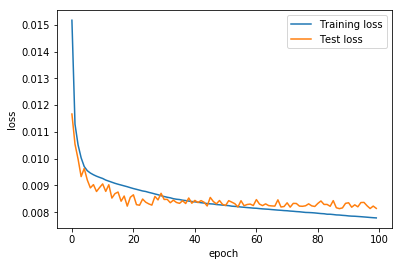

Model MAE: 1.3028327394695276
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


C:\Users\ngu124\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\ngu124\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ngu124\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


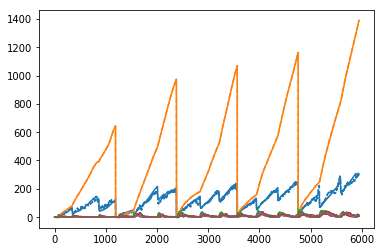

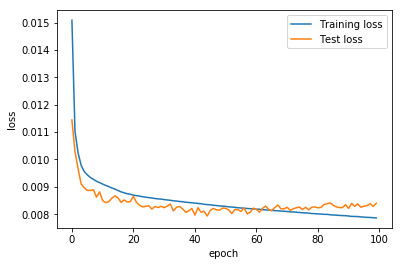

Model MAE: 1.3937806013589167
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


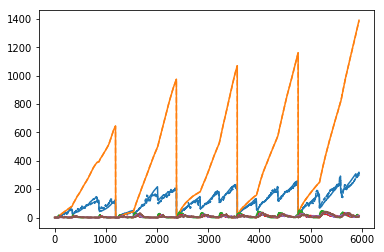

Step ahead:  2


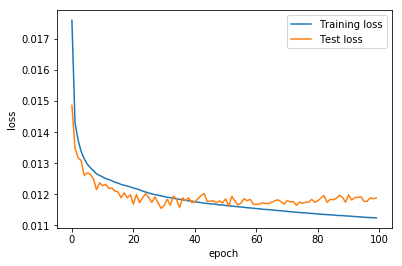

Model MAE: 1.5987825858870899
Naive MAE: nan
Model MAPE: nan
Naive MAPE: nan


C:\Users\ngu124\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


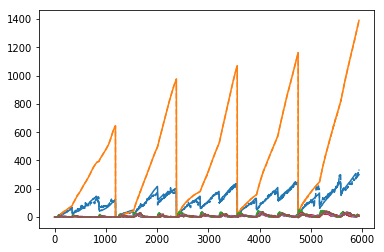

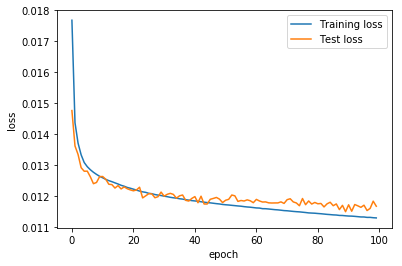

Model MAE: 1.4958827420798146
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


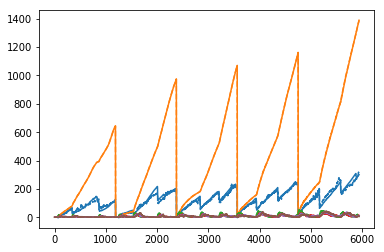

Step ahead:  3


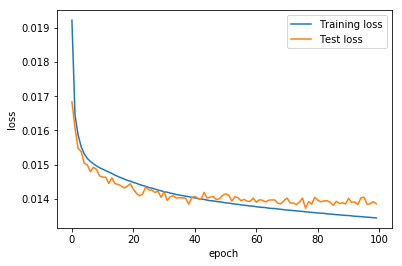

Model MAE: 1.5775698722738887
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


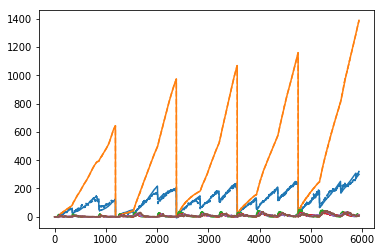

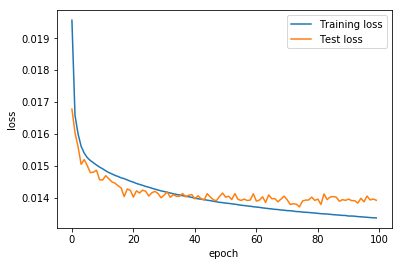

Model MAE: 1.6236933266129105
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


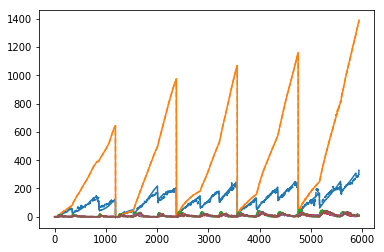

Step ahead:  4


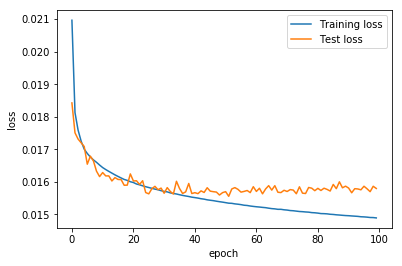

Model MAE: 1.8094677223946825
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


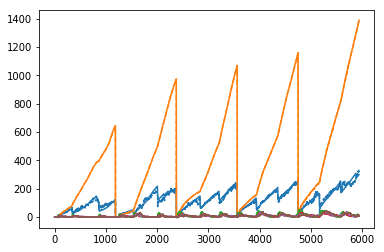

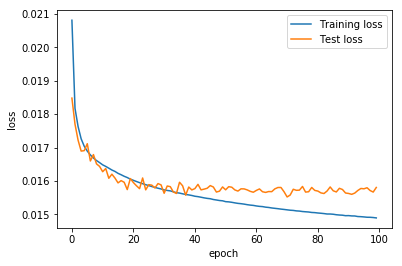

Model MAE: 1.7936853770575825
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


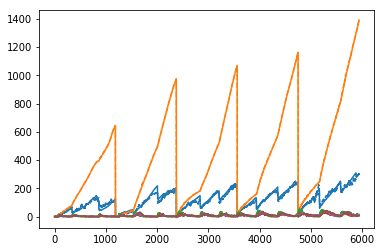

Step ahead:  5


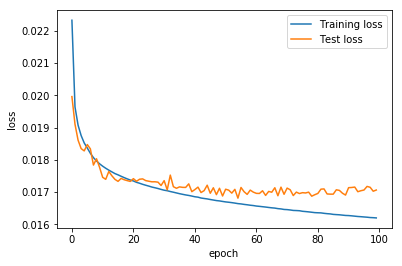

Model MAE: 1.7768909117461709
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


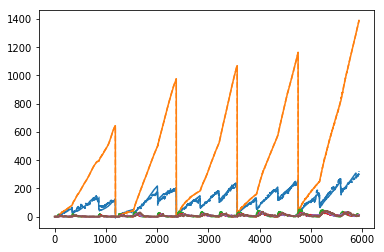

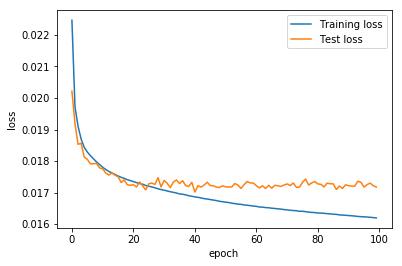

Model MAE: 1.8548656511656267
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


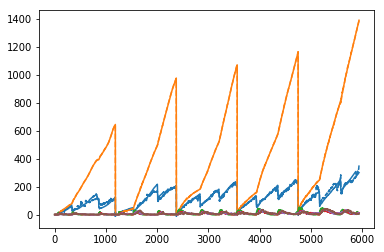

In [45]:
#train and test on all dataset
train_files = ['./Agent_data/df_pop_'+str(i)+'00_v5.csv' for i in range(1,6)]
test_files = ['./Agent_data/df_pop_'+str(i)+'00_test_v5.csv' for i in range(1,6)]
df_train = pd.concat([pd.read_csv(f) for f in train_files], ignore_index = True)
df_test = pd.concat([pd.read_csv(f) for f in test_files], ignore_index= True)

time_train = df_train['# Time']
print(time_train[5])
time_test = df_test['# Time']

df_train = df_train.drop(['# Time'], axis=1)
df_test = df_test.drop(['# Time'], axis=1)

datatrain = df_train.values
datatest = df_test.values
    
for m in range(1,6):
    print("Step ahead: ", m)
    train_X, train_y, test_X, test_y, scaler = prepare_data(datatrain, datatest, time_train, time_test, m, 5)
    results = train_nn(train_X, train_y, test_X, test_y, scaler, m, 5)
    test_rescpred, test_rescref = train_nn(train_X, train_y, test_X, test_y, scaler, m, 5)
    test_rescpred = pd.DataFrame(test_rescpred)
    test_rescref = pd.DataFrame(test_rescref)
    test_rescpred.to_csv("./outputs/Testv5allpredict"+str(m)+".csv")
    test_rescref.to_csv("./outputs/Testv5allreal"+str(m)+".csv")

Test data:  1
Step ahead:  1


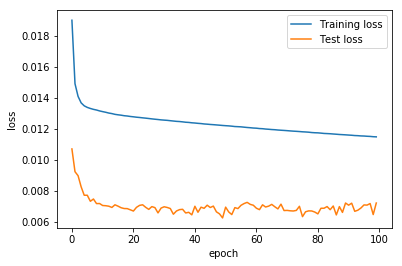

Model MAE: 1.9376351881310945
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


C:\Users\ngu124\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\ngu124\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ngu124\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


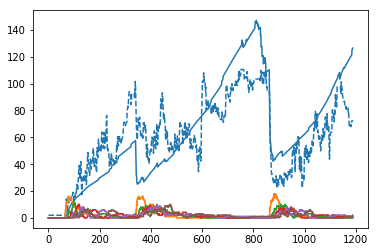

Step ahead:  2


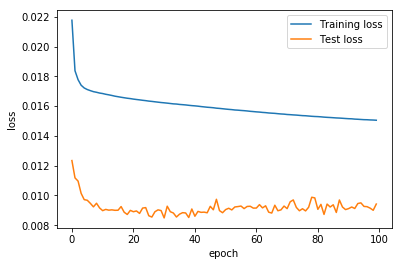

Model MAE: 2.157215942364286
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


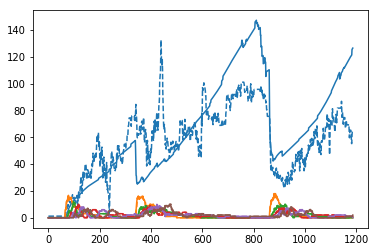

Step ahead:  3


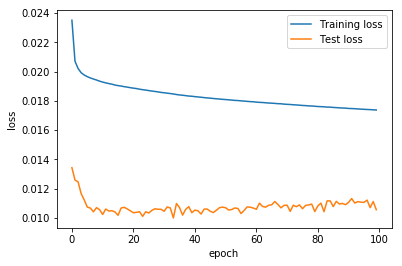

Model MAE: 2.072932021446019
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


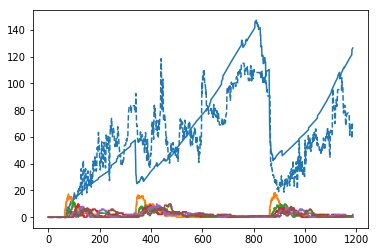

Step ahead:  4


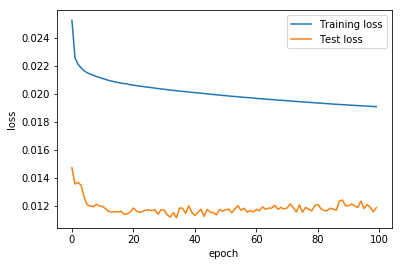

Model MAE: 2.175272378494168
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


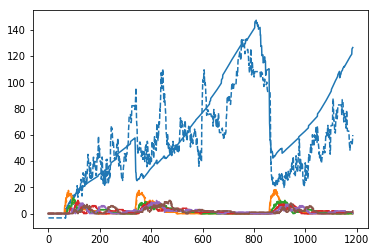

Step ahead:  5


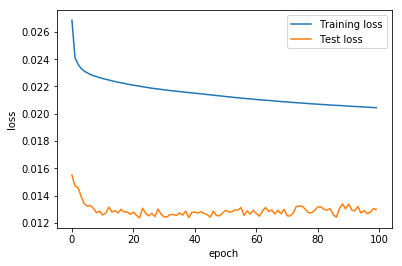

Model MAE: 2.347801685780881
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


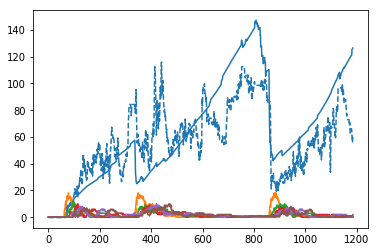

Test data:  2
Step ahead:  1


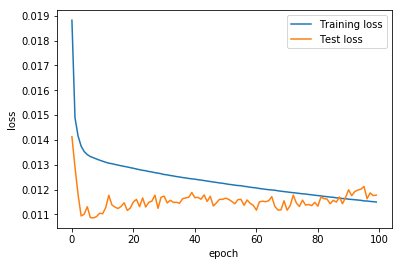

Model MAE: 3.0483171597013454
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


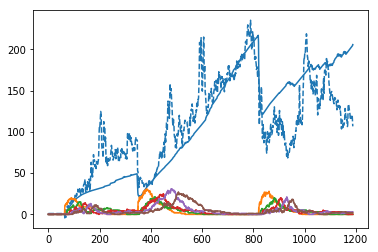

Step ahead:  2


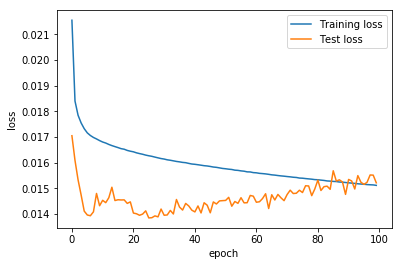

Model MAE: 3.3017046959738408
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


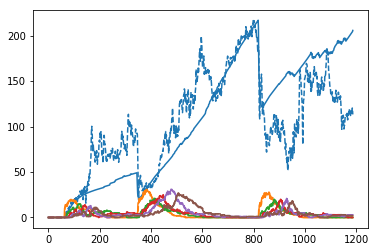

Step ahead:  3


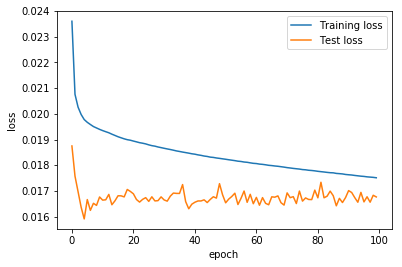

Model MAE: 3.1549917817216113
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


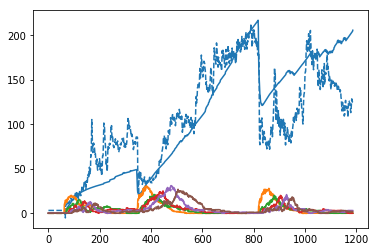

Step ahead:  4


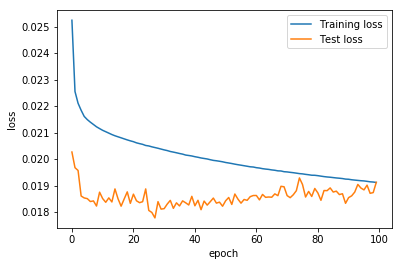

Model MAE: 3.4458065286331427
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


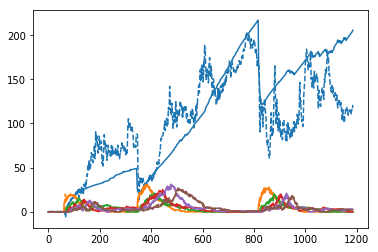

Step ahead:  5


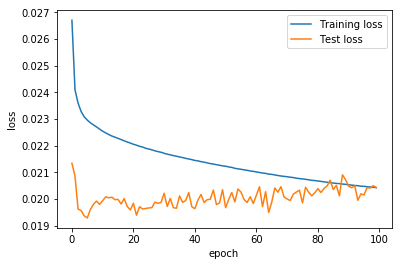

Model MAE: 3.454061740413676
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


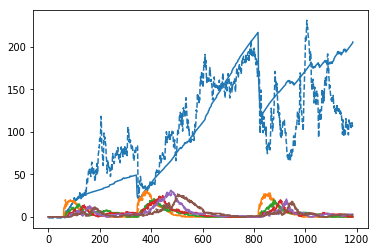

Test data:  3
Step ahead:  1


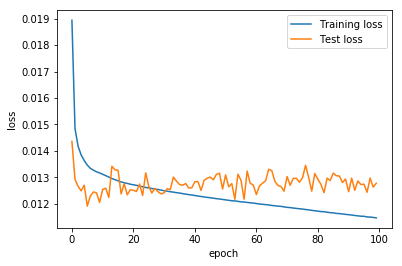

Model MAE: 2.7844080665261925
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


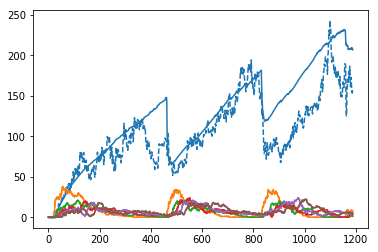

Step ahead:  2


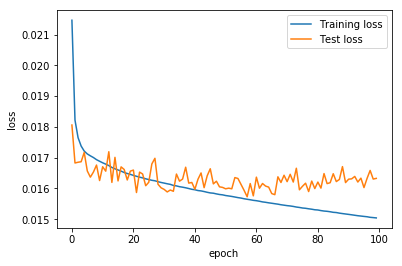

Model MAE: 2.7911592686735105
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


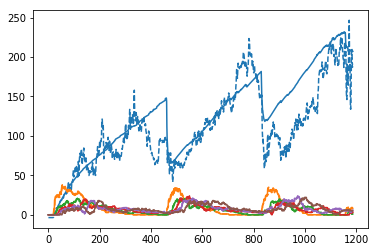

Step ahead:  3


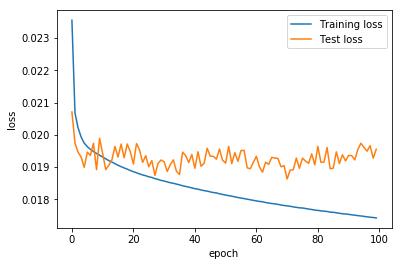

Model MAE: 3.1607142932027212
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


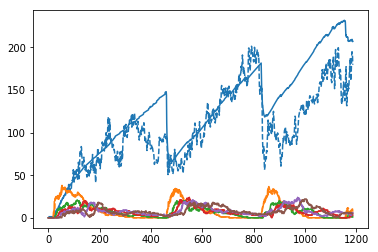

Step ahead:  4


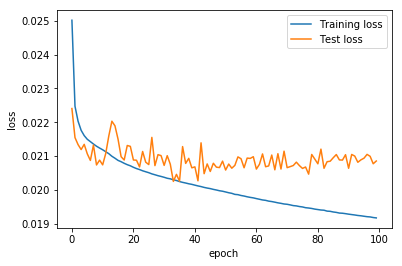

Model MAE: 3.061195599377369
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


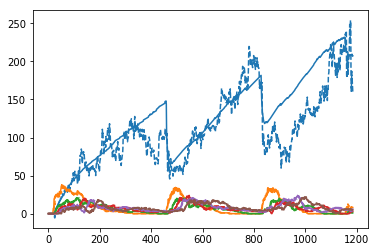

Step ahead:  5


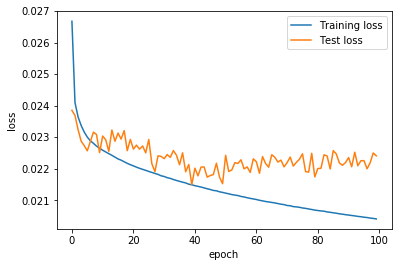

Model MAE: 3.075741554856723
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


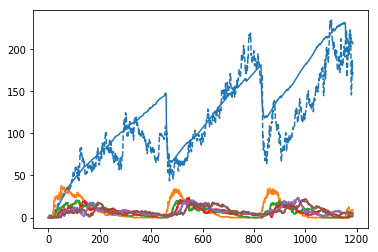

Test data:  4
Step ahead:  1


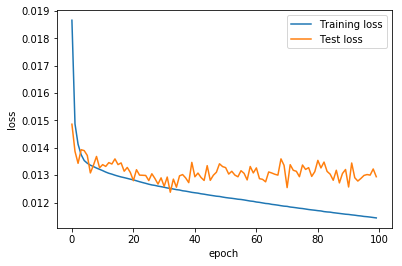

Model MAE: 2.313707003364763
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


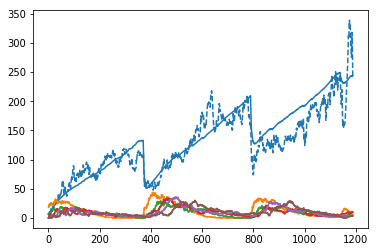

Step ahead:  2


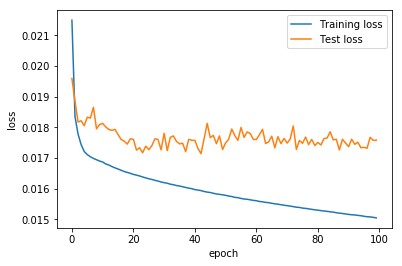

Model MAE: 2.537811680921772
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


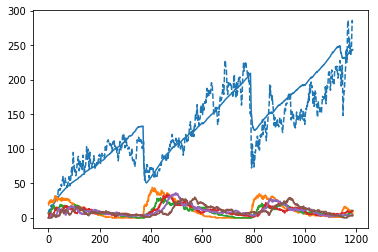

Step ahead:  3


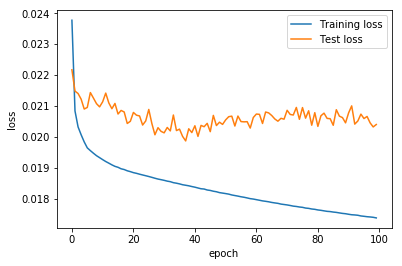

Model MAE: 2.615702247266313
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


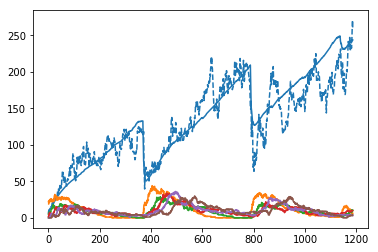

Step ahead:  4


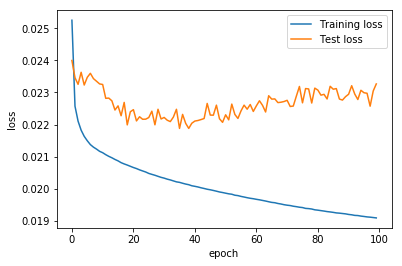

Model MAE: 3.0526225959955866
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


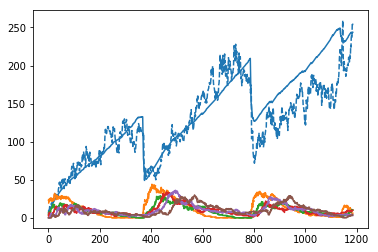

Step ahead:  5


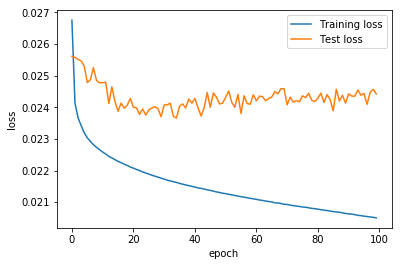

Model MAE: 2.8849237325712638
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


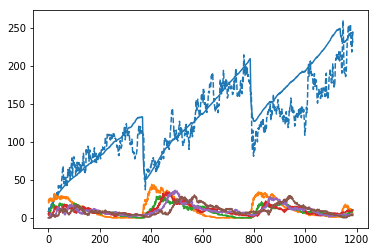

Test data:  5
Step ahead:  1


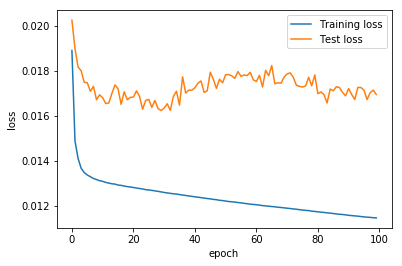

Model MAE: 3.4200244289643735
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


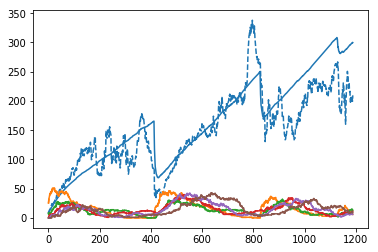

Step ahead:  2


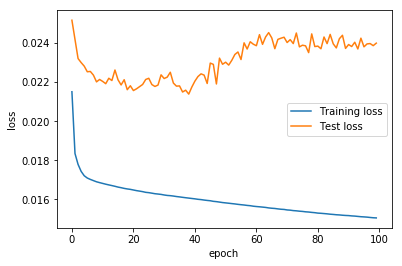

Model MAE: 4.354811177123463
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


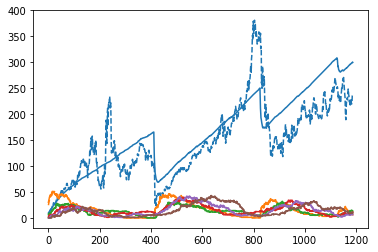

Step ahead:  3


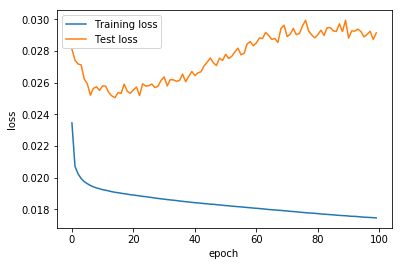

Model MAE: 5.010158744308997
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


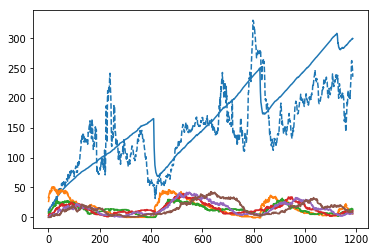

Step ahead:  4


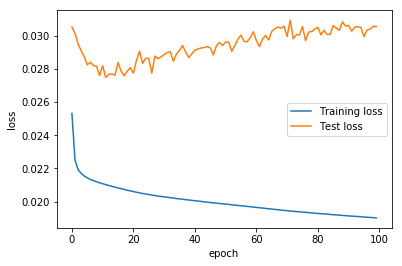

Model MAE: 4.63188433259276
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


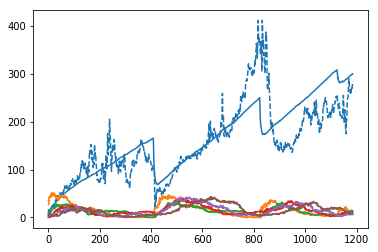

Step ahead:  5


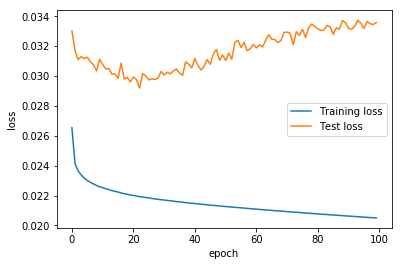

Model MAE: 4.907020887797213
Naive MAE: nan
Model MAPE: inf
Naive MAPE: nan


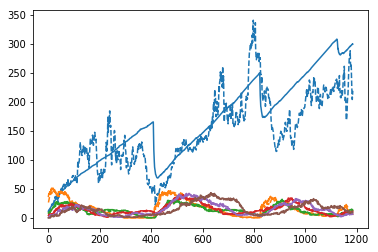

In [46]:
#train and test on all dataset
train_files = ['./Agent_data/df_pop_'+str(i)+'00_v5.csv' for i in range(1,6)]
df_train = pd.concat([pd.read_csv(f) for f in train_files], ignore_index = True)
time_train = df_train['# Time']
df_train = df_train.drop(['# Time'], axis=1)
df_train = df_train.drop(['Collisions'], axis=1)
datatrain = df_train.values

for k in range(1,6):
    print("Test data: ", k)
    df_test = pd.read_csv('./Agent_data/df_pop_'+str(k)+'00_test_v5.csv')
    time_test = df_test['# Time']    
    df_test = df_test.drop(['# Time'], axis=1)
    df_test = df_test.drop(['Collisions'], axis=1)
    #df_test
    datatest = df_test.values
    for m in range(1,6):
        print("Step ahead: ", m)
        train_X, train_y, test_X, test_y, scaler = prepare_data(datatrain, datatest, time_train, time_test, m, 5)
        test_rescpred, test_rescref = train_nn(train_X, train_y, test_X, test_y, scaler, m, 5)
        test_rescpred = pd.DataFrame(test_rescpred)
        test_rescref = pd.DataFrame(test_rescref)
        test_rescpred.to_csv("./outputs/Testv5"+str(k)+"predict"+str(m)+".csv")
        test_rescref.to_csv("./outputs/Testv5"+str(k)+"real"+str(m)+".csv")

In [4]:
#Each population LSTM

from sys import path
path.append('..')

columns = [0, 1, 2, 3, 4]
maes = pd.DataFrame(columns=columns)
rmses = pd.DataFrame(columns=columns)
for k in range(1,6):
    #print("Evalue data: ", k)
    mae = []
    rmse = []
    for m in range(1,6):
        #print("Step ahead: ", m)
        predicts = pd.read_csv("../outputs/LSTM/test/Testv5"+str(k)+"predict"+str(m)+".csv")
        reals = pd.read_csv("../outputs/LSTM/test/Testv5"+str(k)+"real"+str(m)+".csv")
        #print(mean_absolute_error(predicts[0].values, reals[0].values))
        mae.append(mean_absolute_error(predicts['0'].values, reals['0'].values))
        rmse.append(sqrt(mean_squared_error(predicts['0'].values, reals['0'].values)))
    mae = pd.Series(mae)
    #print(mae)
    mae = pd.DataFrame([mae])
    #print(mae)
    rmse = pd.Series(rmse)
    rmse = pd.DataFrame([rmse])
    maes = pd.concat([maes, mae], ignore_index=True)
    rmses = pd.concat([rmses, rmse], ignore_index=True)
print(maes)
print(rmses)

           0          1          2          3          4
0  20.069908  21.256333  21.282253  22.048561  21.107040
1  31.914190  33.142019  34.419572  32.351452  30.706146
2  22.801840  24.143790  24.305824  25.447827  24.532345
3  17.078595  13.410344  13.345992  13.217698  17.101558
4  27.526113  23.949485  27.571020  22.666528  23.785078
           0          1          2          3          4
0  24.635091  26.380261  26.298440  27.721281  25.579411
1  40.856671  42.618253  47.738321  42.770382  41.442648
2  29.728472  31.164425  30.695210  31.993352  30.541540
3  22.751628  18.179246  17.665709  17.511192  24.339666
4  38.842838  33.530061  40.254706  29.846046  40.082566


In [2]:
#Train all population, test each LSTM

from sys import path
path.append('..')

columns = [0, 1, 2, 3, 4]
maes = pd.DataFrame(columns=columns)
rmses = pd.DataFrame(columns=columns)
for k in range(1,6):
    #print("Evalue data: ", k)
    mae = []
    rmse = []
    for m in range(1,6):
        #print("Step ahead: ", m)
        predicts = pd.read_csv("../outputs/LSTM/all/Testv5"+str(k)+"predict"+str(m)+".csv")
        reals = pd.read_csv("../outputs/LSTM/all/Testv5"+str(k)+"real"+str(m)+".csv")
        #print(mean_absolute_error(predicts[0].values, reals[0].values))
        mae.append(mean_absolute_error(predicts['0'].values, reals['0'].values))
        rmse.append(sqrt(mean_squared_error(predicts['0'].values, reals['0'].values)))
    mae = pd.Series(mae)
    #print(mae)
    mae = pd.DataFrame([mae])
    #print(mae)
    rmse = pd.Series(rmse)
    rmse = pd.DataFrame([rmse])
    maes = pd.concat([maes, mae], ignore_index=True)
    rmses = pd.concat([rmses, rmse], ignore_index=True)
print(maes)
print(rmses)

           0          1          2          3          4
0  18.042757  19.291516  17.690539  18.127498  19.453971
1  28.146531  29.070987  26.516865  28.518200  27.819549
2  24.507739  22.539241  24.909847  22.996942  22.195649
3  19.037297  18.942016  18.214927  21.512007  18.962318
4  29.390695  36.030480  40.547015  35.314244  36.632079
           0          1          2          3          4
0  21.790409  24.390939  21.782353  23.043411  24.232959
1  37.225632  38.623017  34.168753  36.898389  37.029995
2  33.208498  30.706001  33.915145  31.042348  29.844488
3  25.273321  24.440455  24.365619  28.697448  25.448223
4  38.979928  45.702945  50.394338  50.101964  46.008076


In [5]:
#Each population training and testing RF

columns = [0, 1, 2, 3, 4]
maes = pd.DataFrame(columns=columns)
rmses = pd.DataFrame(columns=columns)
for k in range(1,6):
    #print("Evalue data: ", k)
    mae = []
    rmse = []
    for m in range(1,6):
        #print("Step ahead: ", m)
        predicts = pd.read_csv("../outputs/RF/Test_pop"+str(k)+"00_predict_SH"+str(m)+"_RF.csv")
        reals = pd.read_csv("../outputs/RF/Test_pop"+str(k)+"00_real_SH"+str(m)+"_RF.csv")
        #print(mean_absolute_error(predicts[0].values, reals[0].values))
        mae.append(mean_absolute_error(predicts['10'].values, reals['10'].values))
        rmse.append(sqrt(mean_squared_error(predicts['10'].values, reals['10'].values)))
    mae = pd.Series(mae)
    #print(mae)
    mae = pd.DataFrame([mae])
    #print(mae)
    rmse = pd.Series(rmse)
    rmse = pd.DataFrame([rmse])
    maes = pd.concat([maes, mae], ignore_index=True)
    rmses = pd.concat([rmses, rmse], ignore_index=True)
print(maes)
print(rmses)

           0          1          2          3          4
0  18.352703  18.062964  18.471706  19.010256  19.367918
1  32.153431  31.324369  31.572290  31.463370  31.643188
2  21.712846  21.944134  21.821100  21.863907  22.023597
3  18.304296  17.942543  18.800941  18.478095  18.237655
4  22.528335  22.304370  22.811414  23.921145  23.696517
           0          1          2          3          4
0  25.830318  25.578528  25.482771  26.118200  26.251810
1  42.290868  41.948798  42.746807  42.508362  43.276599
2  28.015909  28.344748  28.268520  28.327518  28.616330
3  25.011479  25.224889  26.516562  25.820290  24.978206
4  30.255853  29.847237  30.954960  33.195704  33.243730


In [6]:
#Train on all population, test separately RF

columns = [0, 1, 2, 3, 4]
maes = pd.DataFrame(columns=columns)
rmses = pd.DataFrame(columns=columns)
for k in range(1,6):
    #print("Evalue data: ", k)
    mae = []
    rmse = []
    for m in range(1,6):
        #print("Step ahead: ", m)
        predicts = pd.read_csv("../outputs/RF/All_pop"+str(k)+"00_predict_SH"+str(m)+"_RF.csv")
        reals = pd.read_csv("../outputs/RF/All_pop"+str(k)+"00_real_SH"+str(m)+"_RF.csv")
        #print(mean_absolute_error(predicts[0].values, reals[0].values))
        mae.append(mean_absolute_error(predicts['10'].values, reals['10'].values))
        rmse.append(sqrt(mean_squared_error(predicts['10'].values, reals['10'].values)))
    mae = pd.Series(mae)
    #print(mae)
    mae = pd.DataFrame([mae])
    #print(mae)
    rmse = pd.Series(rmse)
    rmse = pd.DataFrame([rmse])
    maes = pd.concat([maes, mae], ignore_index=True)
    rmses = pd.concat([rmses, rmse], ignore_index=True)
print(maes)
print(rmses)

           0          1          2          3          4
0  20.762334  20.405464  21.686327  21.676417  22.292752
1  28.724987  28.476857  28.317016  28.133104  29.161166
2  25.480686  25.490876  25.510196  26.098824  25.687557
3  20.665419  20.881383  20.847938  20.376859  20.454583
4  32.267394  31.881732  32.428532  32.691050  32.487018
           0          1          2          3          4
0  27.035947  26.812284  28.249220  28.260952  29.193401
1  37.513813  37.384917  37.267260  36.934158  37.802673
2  33.749779  33.640029  33.791742  34.435471  33.887943
3  26.450753  26.967444  27.432342  27.145890  27.954682
4  41.106416  40.857676  41.359404  41.817606  41.652350
